## TwoStep
This method will use a **2-step method** for **positive-unlabeled** classifier learning [(Kaboutari, et al. 2014)](https://www.semanticscholar.org/paper/An-Evaluation-of-Two-Step-Techniques-for-Learning-Kaboutari-Bagherzadeh/bd10ba5f30744e4755cbe7757e8c657ce5d6ec45)
1. Choose datapoints (droplets) that are confidently positive for the given label (in our case, empty droplets and dead cells)
2. Use some method of determining datapoints (droplets) that are confidently negative for the given label (we can use UMI ranking and MT enrichment of clusters)

In [1]:
from QC import *
sc.settings.set_figure_params(dpi=80)

In [ ]:
# reload fcc module while working
import sys
del sys.modules['QC']
from QC import *

### Load data and preprocess

Read in normal human colon sample

In [2]:
%time s1 = sc.read_h5ad('data/3247-AS-1-GCCAAT_S1_labeled.h5ad')

CPU times: user 8.01 s, sys: 1.41 s, total: 9.42 s
Wall time: 9.48 s


In [3]:
s1 # see what's in our object

AnnData object with n_obs × n_vars = 19128 × 41569 
    obs: 'mean_mito', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'label'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Find inflection point

Inflection point at index
bcEGRW     3541
bcGOPG     5895
bcFVGH     8972
bcFUGA    12242
bcGPGA    15618
bcDZKU    19127
Name: total_counts, dtype: int64 for [0, 20, 40, 60, 80, 100] percentiles of greatest secant distances


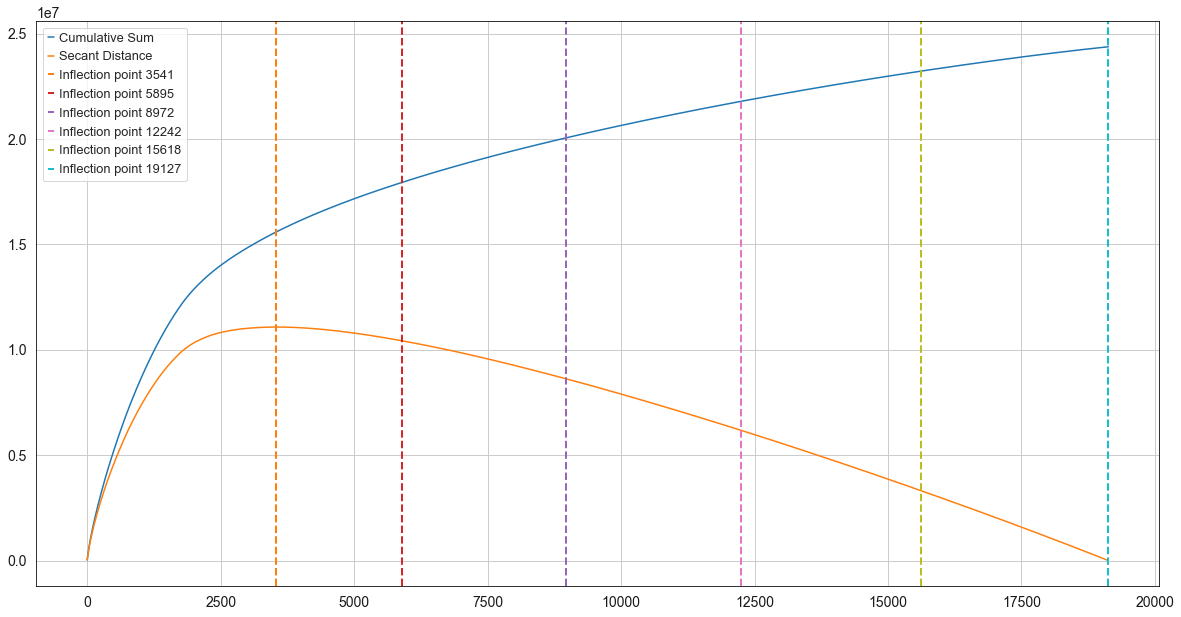

In [4]:
find_inflection(s1, inflection_percentiles = [0,20,40,60,80,100])

In [5]:
s1.obs['total_counts'][12242] # see the total counts at 80th percentile of secant distance (beyond inflection point)

473.0

In [6]:
s1.obs['total_counts'][3541] # see the total counts at inflection point

1275.0

In [11]:
# create new "observation" as empty droplet label
s1.obs['twostep_empty'] = np.where(s1.obs['total_counts']<=s1.obs['total_counts'][12242], 1, -1) # 1 is empty, -1 is unlabeled
s1.obs.loc[s1.obs['ranked_total_counts']>=s1.n_obs*0.97, 'twostep_empty'] = 0 # take top 3% of dataset by total UMI counts and add as "not empty"

In [12]:
s1.obs['twostep_empty'].value_counts()

-1    11645
 1     6910
 0      573
Name: twostep_empty, dtype: int64

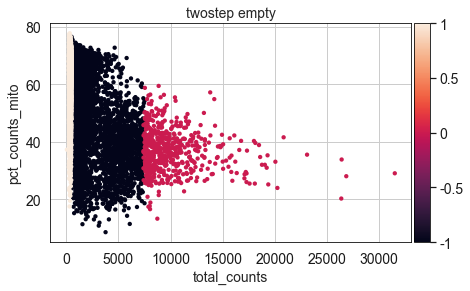

In [13]:
# look at the training labels we've picked
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='twostep_empty', size=75)

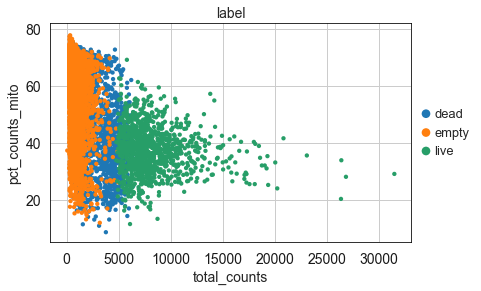

In [14]:
# look at our previously-defined labels
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='label', size=75)

### Normalize and perform linear dimensionality reduction with PCA
Principal components will be fed into classifiers to speed up processing time by reducing gene dimensions to 100 from 40k+.

In [15]:
%%time
sc.pp.normalize_total(s1, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) # log1p transformation
sc.pp.scale(s1, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 4.87 s, sys: 799 ms, total: 5.67 s
Wall time: 5.67 s


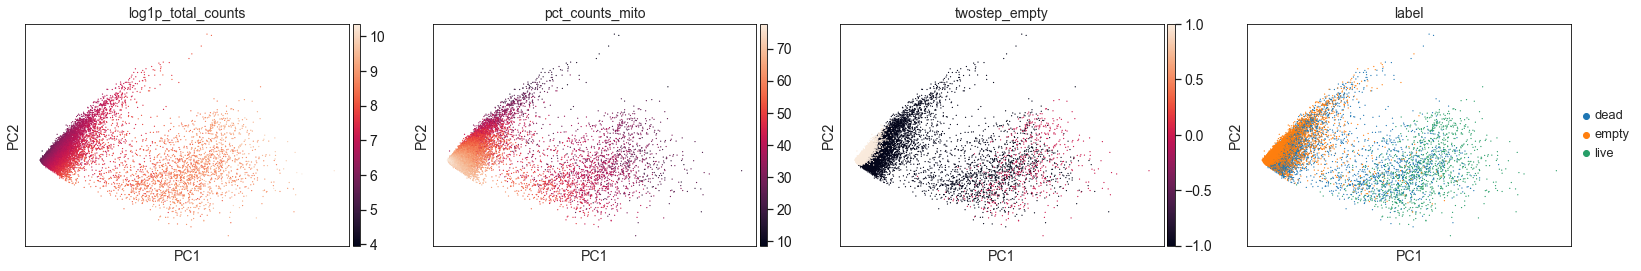

CPU times: user 1min 51s, sys: 4.69 s, total: 1min 56s
Wall time: 22.5 s


In [16]:
%%time
sc.tl.pca(s1, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1, color=['log1p_total_counts','pct_counts_mito','twostep_empty','label'], ncols=4)

In [17]:
# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['twostep_empty'].copy(deep=True) # training labels are from .obs df

In [18]:
# train a classifier on the 0s and 1s from our labeled set of droplet datapoints
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1) # define random forest classifier
rf.fit(X=X[y>=0], y=y[y>=0])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [19]:
# get scores for all points
pred = rf.predict_proba(X)[:,1]

# find range of scores given to positive (empty) droplets
range_P = [min(pred * (y > 0)), max(pred * (y >0))]

In [20]:
# STEP 1
# If any unlabeled point has a score above all known positives, 
# or below all known positives, label it accordingly
iP_new = y[(y < 0) & (pred >= range_P[1])].index
iN_new = y[(y < 0) & (pred <= range_P[0])].index
y.loc[iP_new] = 1
y.loc[iN_new] = 0

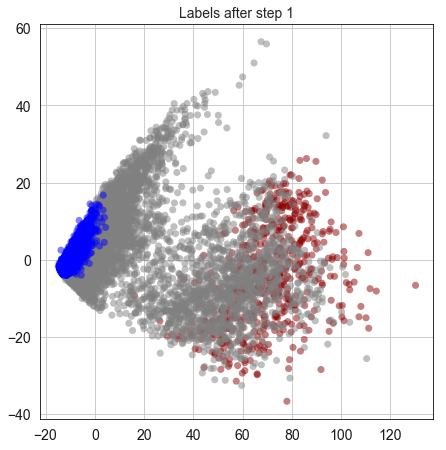

In [21]:
# Show the results of step 1
plt.rcParams['figure.figsize'] = 7,7
cdict = {-1:'gray', 0:'darkred', 1:'blue'}
plt.scatter(
    X[:,0], X[:,1], 
    c = [cdict[k] for k in y], 
    linewidth = 0, s = 50, alpha = 0.5
)
plt.title('Labels after step 1')
plt.show()

In [22]:
# Classifier to be used for step 2
rf2 = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)

# Limit to 10 iterations (this is arbitrary, but 
# otherwise this approach can take a very long time)
for i in range(10):
    # If step 1 didn't find new labels, we're done
    if len(iP_new) + len(iN_new) == 0 and i > 0:
        break
    
    print(
        'Step 1 labeled %d new positives and %d new negatives.' 
        % (len(iP_new), len(iN_new))
    )
    print('Doing step 2... ', end = '')
    
    # STEP 2
    # Retrain on new labels and get new scores
    rf2.fit(X, y)
    pred = rf2.predict_proba(X)[:,-1]
    
    # Find the range of scores given to positive data points
    range_P = [min(pred * (y > 0)), max(pred * (y > 0))]
    
    # Repeat step 1
    iP_new = y[(y < 0) & (pred >= range_P[1])].index
    iN_new = y[(y < 0) & (pred <= range_P[0])].index
    y.loc[iP_new] = 1
    y.loc[iN_new] = 0
    
    
# get scores assigned
results_twostep_empty = pred

Step 1 labeled 2322 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 69 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 59 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 43 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 37 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 33 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 22 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 22 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 19 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 19 new negatives.
Doing step 2... 

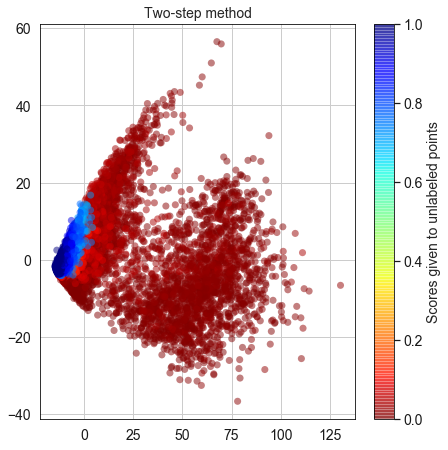

In [23]:
# visualize final TwoStep results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    X[:,0], X[:,1], 
    c = results_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()